In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Reproduce Watsons's K-means result

For this part, I am reusing my code from homework 9 to reproduce Watson's k-means result

In [23]:
def initialize_means(X, k):
    """
    Randomly initialize a centroid by selecting randomly from the dataset X.

    Returns:
    - centroid = a random centroid positions
    """

    centroids = X[np.random.choice(X.shape[0], k, replace=False)]

    return centroids

def assignment(X, centroids): 
    """
    Perform the assginment step, where we assign each data point X_i to its closest 
    centroid μ_k.
    
    Input:
        coords  : the mapped read counts data for the two genes.
        centers : the current centroid positions.
    Output:
        clusters: the cluster assignments for each data point after assigning each 
                  to the closest centroid.
        distance: the total squared distance for all data points relative to the 
                  respective centroids. 
    """
      
    # for each data point, get all distances relative to each centroid and assign 
    # the data point to the closest centroid/cluster.
    clusters =  [np.argmin([dis.euclidean(i, point) for i in centers]) for point in coords]
    
    # get the distance between each point and its closest centroid.
    distances = [np.min([dis.euclidean(i, point) for i in centers]) for point in coords]
        
    # sum over all distances to get the total squared distance.
    distance = sum(distances)
    
    return clusters, distance

def update(coords, clusters, k):
    """
    Perform the update step, where we calculate the new centroids μ_k.
    
    Input:
        coords  : the mapped read counts data for the two genes.
        clusters: the cluster assignments for each data point.
        k       : the number of clusters.
    Output:
        centers : the updated centroid positions after averaging.s
    """
    coords = np.asarray(coords)
    
    # for each point belonging to a cluster, get the index of that cluster.
    clusters = [np.where(np.asarray(clusters) == i) for i in range(k)]
    
    # for each point belonging to a cluster, get the averaged position of those 
    # points and set them as the new centroids.
    centers = [np.mean(coords[clusters[i]], 0).tolist() for i in range(len(clusters))]
    
    return centers

def initialize_mean(X):
    """
    Randomly initialize a centroid by selecting randomly from the dataset X.

    Returns:
    - centroid = a random centroid positions
    """

    centroid = X[np.random.choice(X.shape[0])]

    return centroid

def euclidean_dist(p1, p2):
    """
    Parameters:
    - p1: point 1
    - p2: point 2
    
    Returns: euclidean distance between two points
    """
    d = 0
    for i in range(len(p1)):
        # distance formula
        d += (p1[i] - p2[i])**2

    d = np.sqrt(d)
    return d

# identify the closest centroid for each data point using calculated euclidean distance
# assign that data point to that centroid
def closest_centroid(x, centroids):
    """
    Parameters:
    - centroids: current centroid positions as generated by intialize_means
    - x: one data point
    
    Returns:
    - best_k: index of the best centroid (for x)
    - best_d: distance to the best centroid (for x)
    """

    # K = number of centroids; in this problem set, k = 5
    K = centroids.shape[0]
    
    # set the "best cluster" to the first cluster, or cluster 0 
    best_cluster = 0
    
    # set the "best distance" to the distance between the data point and the first centroid (centroid of cluster 0)
    best_dist = euclidean_dist(x, centroids[0])
   
    # iterate through the list of centroids starting from the second centroid
    
    for k in range(1, K):
        # perform distance calculations for each of the centroids and data points to find the closest one
        dist = euclidean_dist(x, centroids[k])
        # minimize the distance between the data point and the centroid
        if dist < best_dist:
            # set the cluster index as best_cluster for this particular centroid
            best_cluster = k
            # record the distance between the best_cluster cluster and the current data point
            best_dist = dist
    
    return best_cluster, best_dist

# here, we actually implement the k-means assignment
def assign_kmeans(X, centroids):
    """
    Inputs:
    - centroids: list of centroid positions as generated by intialize_means
    - X: the data 
   
    Returns:
    - assignments: list that records the assignment of each data point i to cluster k (from 0-4)
    - tot_sqdist: total squared distance (k-means objective function)
    """
    
    # K = number of centroids
    K = centroids.shape[0]

    # number of points
    N = len(X)
    
    # initialize a N x 1 array of zeros to store the assignment of points to a centroid
    assignments = np.zeros(N).astype(int)

    # initialize the total square distance measure
    tot_sqdist = 0
    
    # assigning actual centroid/cluster identity and adding to total square distance 
    # i: index of a point
    # x: the actual data point
    for i, x in enumerate(X):
        # assignment of data point is stored in assignments[i]
        assignments[i], dist = closest_centroid(x, centroids)
        
        # total squared distance
        tot_sqdist += dist ** 2
    
    return assignments, tot_sqdist

# k-means update step to calculate new centroid positions, given assignments of data points
# need to avoid empty centroids or outliers (force convergence)
def update_kmeans(X, assignments, K):
    """
    Inputs:
    - X: the data 
    - assignments: assignment of each data point i (represented as assignment[i]) to cluster k
    - K: number of centroids/clusters
    
    Returns:
    - Updated centroid positions
    - counts[k] = frequency of using component k (aka how many points were assigned to it, normalized)
    """

    # N: number of cells (rows of the data file)
    # G: number of genes (cols of the data file, after the first)
    N, G = X.shape            
    centroids = np.zeros((K,G))
    counts = np.zeros(K)

    # iterate through each cell
    for i in range(N):
        counts[assignments[i]] += 1
        for g in range(G):
            # iterate through each gene (2 genes)
            centroids[assignments[i], g] += X[i][g]
    
    for k in range(K):
        # if a centroid is not empty, we recalculate the position of the centroid by averaging over the number of points in it
        if counts[k] > 0:                                      
            centroids[k] = centroids[k] / counts[k]
        # if the centroid is empty, we reinitialize it randomly
        else:                                                  
            centroids[k] = initialize_mean(X)

    Z = np.sum(counts)
    counts = np.divide(counts, Z)
    
    return centroids, counts

# checking whether iterative algorithm has converged by seeing if any cluster assignments differ
def diff_assignments(a1, a2):
    """
    Parameters:
    - a1: initial assignments of data points
    - a2: updated assignments of data points
    
    Output:
        ndiff = number of assignments that differ between a1 and a2
    """
    
    N = len(a1)
    ndiff = 0
    
    for i in range(N):
        if a1[i] != a2[i]: 
            ndiff += 1
            
    return ndiff

def kmeans(X, k):
    """
    Parameters:
    - X: dataset
    - k: how many clusters to fit
    
    Returns:
    - 
    """
    
    N, G = np.shape(X)
    
    centroids = np.zeros((K,G))
    for k in range(K):
        centroids[k] = initialize_mean(X)
    
    # checking for convergence and looping through until ndiff = 0 is reached
    iteration = 0
    while True:
        assignments, tot_sqdist = assign_kmeans(X, centroids)

        if iteration >= 1:
            ndiff = diff_assignments(assignments, old_assignments)
            if ndiff == 0:
                break
        centroids, kp = update_kmeans(X, assignments, K)
        old_assignments = assignments
        iteration      += 1
    
    # print("iterations = {}".format(iteration))

    # normalization step
    kp = np.zeros(K)
    for i in range(N):
        kp[assignments[i]] += 1
    
    kp = np.divide(kp, N)

    return kp, centroids, assignments, tot_sqdist

Below, we read in the <code>w11-data.tbl</code> file.

In [24]:
# read in the data
data, genes = [], []

with open('w11-data.tbl') as f:
    for n, line in enumerate(f):
        if n == 0:
            genes = line.split()
        else: 
            fields = line.split()
            data.append([int(i) for i in fields])

# convert data to numpy array
data = np.asarray(data)

logged_data = np.log(data)

In [25]:
K = 8
best_totdist = 1000000000000
best_run = 0
best_centroids = None
best_assignments = None

# selecting the best of 20-100 iterations, as Wiggins did
n_runs = np.random.randint(20, 100)

for run in range(n_runs):
    np.random.seed(run)
    kp, centroids, assignments, tot_sqdist = kmeans(logged_data, K)
    
    if tot_sqdist < best_totdist:
        best_totdist = tot_sqdist
        best_run = run
        best_centroids = centroids
        best_assignments = assignments

In [26]:
print('Lowest total squared distance (best clustering):', best_totdist)

Lowest total squared distance (best clustering): 87522.77226662582


As printed above, our calculated lowest total squared distance is 87522.77, which aligns with Watsons' clustering that achieved a sum of the squared distance to be 87378.2.

## 2. Reduce the dimensionality
Below, we write a Python function called <code>PCA</code>that uses singular value decomposition to find the principal components of the data set. Then we call this function on our data (in logspace).

In [4]:
def PCA(data):
    norm_data = data - np.mean(data, axis=0)
    u, s, vt = np.linalg.svd(norm_data)

    # transpose vt, which is the conjugate transpose of v
    v = vt.T

    # calculate the principal components
    principal_components = norm_data@v

    return u, s, v, principal_components

In [5]:
u, s, v, principal_components = PCA(logged_data)

Below, we plot all 200 cells in 2D PCA space using their projections onto the first two principal axes.

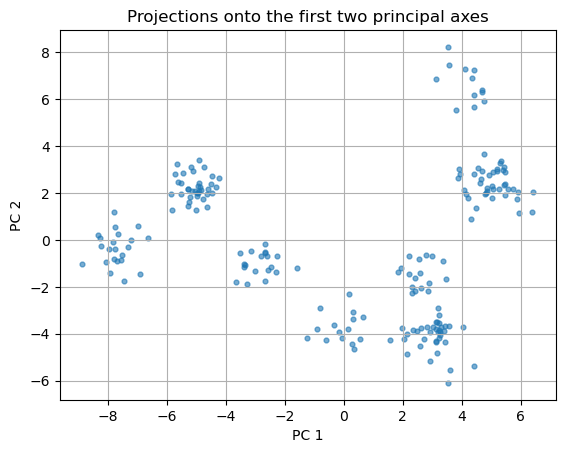

In [6]:
# define our first two principal components
pc_1 = principal_components[:,0]
pc_2 = principal_components[:,1]

fig, ax = plt.subplots()

# plot all 200 cells in 2D PCA space
ax.scatter(pc_1, pc_2, s=12, alpha=0.6)
ax.set(xlabel='PC 1', ylabel='PC 2', title='Projections onto the first two principal axes')
plt.grid()
plt.show()

After performing singular value decomosition on the log-transformed data and plotting the cells using their projections onto the first two principal components, we can see that Watson was right to expect 8 clusters, as we can count 8 clearly defined clusters in the graph above. 

Below, we now plot the eigenvalues for each component, which are given by <code>s**2</code>.

In [7]:
# process the eigenvalues from the simulated negative control data set for processing
neg_control_eig_vals = []

with open('w11-eigen.tbl') as f:
    for n, line in enumerate(f):
        fields = line.split()
        neg_control_eig_vals.append(float(fields[1]))

neg_var_explained = neg_control_eig_vals / np.sum(neg_control_eig_vals)

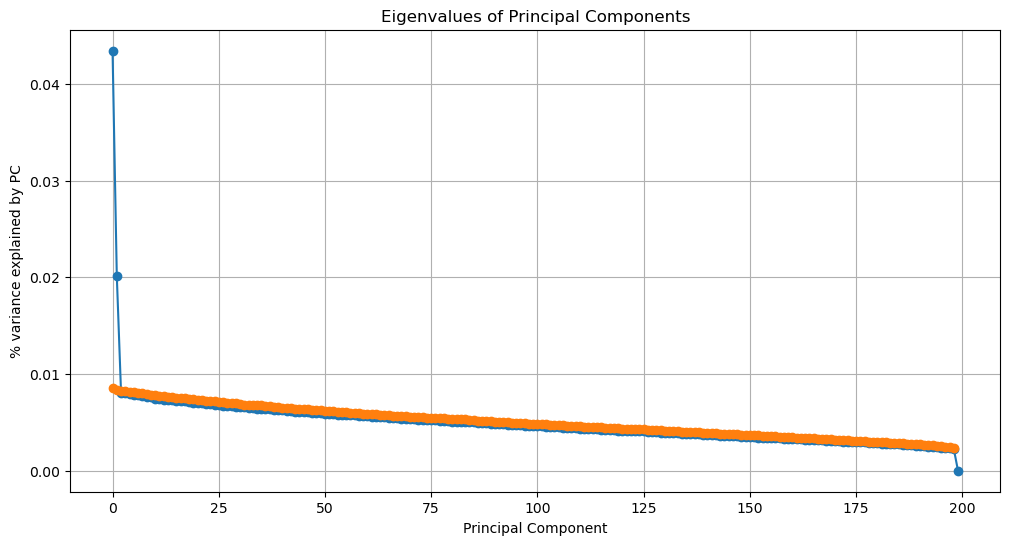

In [41]:
# calculate the eigevnalues using the singular values
eig_vals = s**2 / (data.shape[0] - 1)
var_explained = eig_vals / np.sum(eig_vals)

# plot the eigenvalues
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(range(len(eig_vals)), var_explained, marker='o', linestyle='-')
ax.plot(range(len(neg_control_eig_vals)), neg_var_explained, marker='o', color='C1', linestyle='-')

ax.set(xlabel='Principal Component', ylabel='% variance explained by PC', title='Eigenvalues of Principal Components')
plt.grid()
plt.show()

Based on the plot of the eigenvalues above, we can see that a majority of the variance is explained by the first two principal components. The eigenvalues from a simulated negative control data set, where there were no cell types and no correlations between any of the genes, correspond to the eigenvalues of most of the remaining principal components. This suggests that the remaining principal components may represent noise in our dataset, and that we can be more confident that there are indeed $K=8$ clusters in our data.

Next, we will try to determine the number of influential genes in our data using the eigenvector loadings.

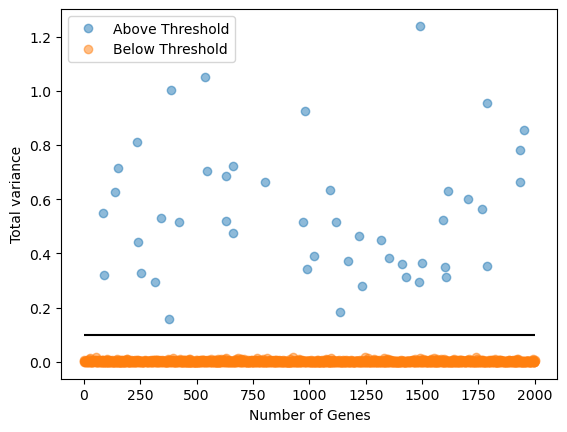

In [84]:
# set the first two eigenvectors
first_eig_vector = v[:, 0]
sec_eig_vector = v[:, 1]

var = (first_eig_vector**2)*eig_vals[0] + (sec_eig_vector**2)*eig_vals[1]

# set threshold for classifying a gene as contributing to the variance
threshold = 0.1

fig, ax = plt.subplots()

# separate the points that exceed vs. that do not exceed the threshold of 0.1 
exceed_threshold = var > threshold
above = np.where(exceed_threshold)[0]
below = np.where(~exceed_threshold)[0]

ax.plot(above, var[above], 'o', alpha = 0.5, label='Above Threshold')
ax.plot(below, var[below], 'o', alpha = 0.5, label='Below Threshold')
ax.hlines(y=threshold, xmin=0, xmax=2000, color = 'black')
ax.set(xlabel='Number of Genes', ylabel ='Total variance')
plt.legend()
plt.show()

In [85]:
influential_genes = len(np.where(exceed_threshold)[0])

print(f"There are {influential_genes} genes that appear to influence cell type identity based on the eigenvector loadings.")

There are 47 genes that appear to influence cell type identity based on the eigenvector loadings.


We can conclude that there are 47 genes that appear to influence cell type identity based on the eigenvector loadings, as there are 47 genes that contribute a significant difference in variance as set by our threshold of 0.1

## 3. Check the clustering

Plot the data in 2D principal component space, and color each point according to the cluster identities from part 1. You should find that K-means is missing the mark.

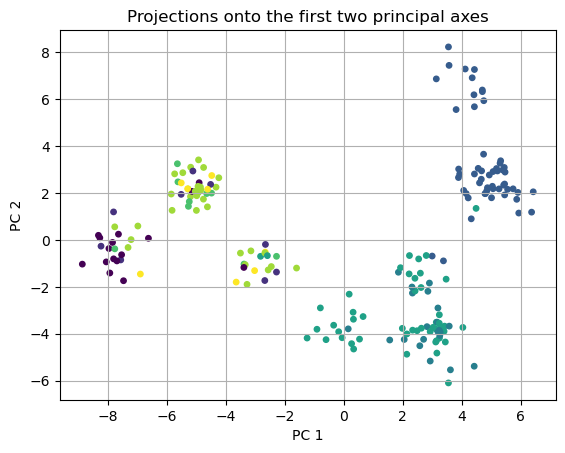

In [57]:
# define our first two principal components
pc_1 = principal_components[:,0]
pc_2 = principal_components[:,1]

fig, ax = plt.subplots()

# plot all 200 cells in 2D PCA space
ax.scatter(pc_1, pc_2, c = best_assignments, s=15)
ax.set(xlabel='PC 1', ylabel='PC 2', title='Projections onto the first two principal axes')
plt.grid()
plt.show()

As mentioned earlier (based on question 2), our k-means clustering seems to be accounting for a lot of noise in the data. A majority of the variance is already accounted for in the first two principal components (the eigenvalues from a simulated negative control data set, where there were no cell types and no correlations between any of the genes, correspond to the eigenvalues of the remaining principal components). In order to remedy this, we could rerun our k-means algorithm using just the 47 genes that we identified to be contributing to the variance in the data.

In [59]:
influential_data = logged_data[:, exceed_threshold]

# 8 clusters
K = 8
best_totdist = 1000000000000
best_run = 0
best_centroids = None
best_assignments = None

# selecting the best of 20-100 iterations, as Wiggins did
n_runs = np.random.randint(20, 100)

for run in range(n_runs):
    np.random.seed(run)
    kp, centroids, assignments, tot_sqdist = kmeans(influential_data, K)
    
    if tot_sqdist < best_totdist:
        best_totdist = tot_sqdist
        best_run = run
        best_centroids = centroids
        best_assignments = assignments

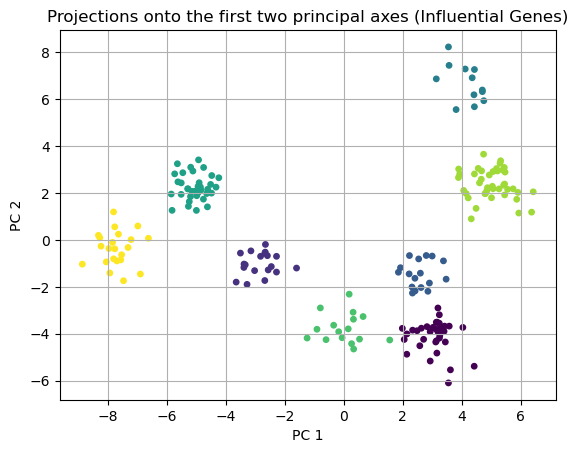

In [61]:
# define our first two principal components  
pc_1 = principal_components[:,0]
pc_2 = principal_components[:,1]

fig, ax = plt.subplots()

# plot all 200 cells in 2D PCA space
ax.scatter(pc_1, pc_2, c = best_assignments, s=15)
ax.set(xlabel='PC 1', ylabel='PC 2', title='Projections onto the first two principal axes (Influential Genes)')
plt.grid()
plt.show()

As we can see in our new graph above after taking a subset of only the 47 most important genes, the clustering algorithm clusters much better into 8 defined clusters in the first two principal axes.

## 4. Reconstruct the expression patterns

Reconstruct the original data set using only the projected data and eigenvectors for the first 2 principal components. Visualize the data using a heat map. Do the clusters now look more obvious? Why or why not?

In [64]:
# reconstruct the data
new_data = u[:, :2] @ np.diag(s[:2]) @ v.T[:2,:]
new_data

array([[ 1.47148490e-02, -2.74001467e-03, -5.11750826e-02, ...,
         9.99413688e-04, -6.13625407e-02,  1.20656884e-01],
       [-7.97170254e-03, -5.18660247e-03, -5.46468023e-02, ...,
         2.48527967e-03, -6.86476659e-02,  1.07348727e-01],
       [ 8.27276676e-02,  1.14686250e-02,  4.41093283e-02, ...,
        -6.57389782e-03,  6.54678888e-02, -1.74141938e-02],
       ...,
       [-5.96243703e-02, -1.14381161e-02, -7.09615199e-02, ...,
         6.17733138e-03, -9.56377761e-02,  9.46834313e-02],
       [-1.00418445e-01, -1.51740710e-02, -6.90127903e-02, ...,
         8.54816356e-03, -9.86049890e-02,  5.35774845e-02],
       [-2.23374906e-02,  4.48756126e-05,  2.68804497e-02, ...,
         3.49677437e-04,  3.03057957e-02, -7.66335336e-02]])

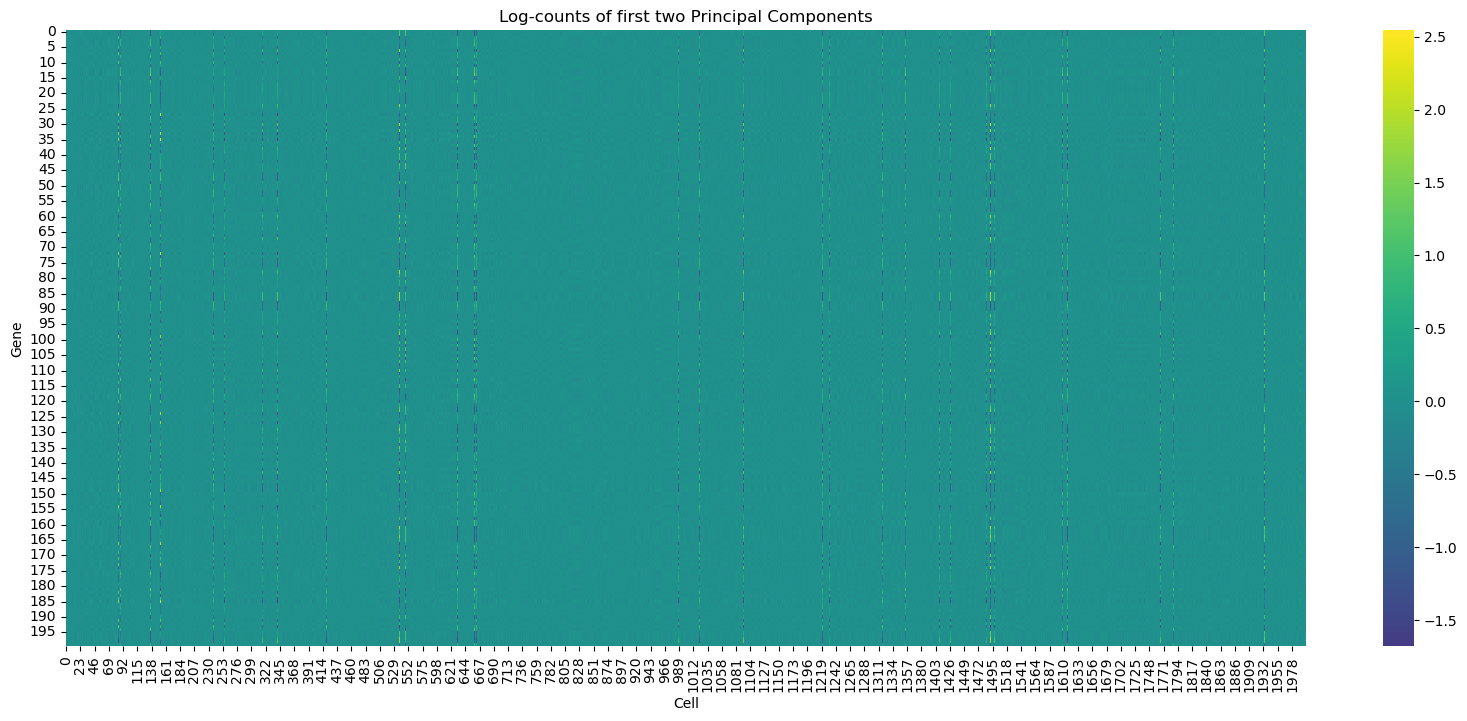

In [71]:
import seaborn as sns

plt.figure(figsize=(20, 8))
sns.heatmap(new_data, cmap='viridis', center=0)
plt.xlabel('Cell')
plt.ylabel('Gene')
plt.title('Log-counts of first two Principal Components')

plt.show()

As observed from our heat map aabove, the clusters now do not really look more obvious. Thus, I tried plotting again after sorting the cells by their cluster assignments first.

In [81]:
# empty list to store sorted data
sorted_data = []  

# empty list to store sorted indices
sorted_indices = [] 

# iterate through each cluster
for i in range(8):
    # get cluster indicies of cluster i
    cluster_indices = np.where(best_assignments == i)[0]  
    
    # base it on the influential data
    cluster_data = influential_data[cluster_indices]
    sorted_data.append(cluster_data)

# concatenate the lists into arrays
sorted_data = np.concatenate(sorted_data, axis=0)

In [82]:
# center the sorted data by subtracting the mean of each column
centered_data = sorted_data - np.mean(influential_data, axis=0)

# perform SVD on the mean-centered data 
u, s, vt = np.linalg.svd(centered_data)

# reconstruct the data
new_data = u[:, :2] @ np.diag(s[:2]) @ vt[:2,:]
new_data

array([[-0.25964489,  0.73432905,  0.90457683, ..., -0.92577973,
        -0.64244352, -0.89805003],
       [-0.17270923,  0.8201005 ,  1.07933192, ..., -0.95278526,
        -0.83077441, -0.90623196],
       [-0.24647637,  0.80001259,  1.00693344, ..., -0.98340962,
        -0.73506876, -0.94836281],
       ...,
       [-1.00099199, -0.32888805, -1.06350653, ..., -0.3583522 ,
         1.36718038, -0.51926273],
       [-0.96420197, -0.35672983, -1.08192518, ..., -0.30460936,
         1.36550515, -0.46299007],
       [-1.22654613,  0.04459713, -0.65852601, ..., -0.89389603,
         1.13075957, -1.05312914]])

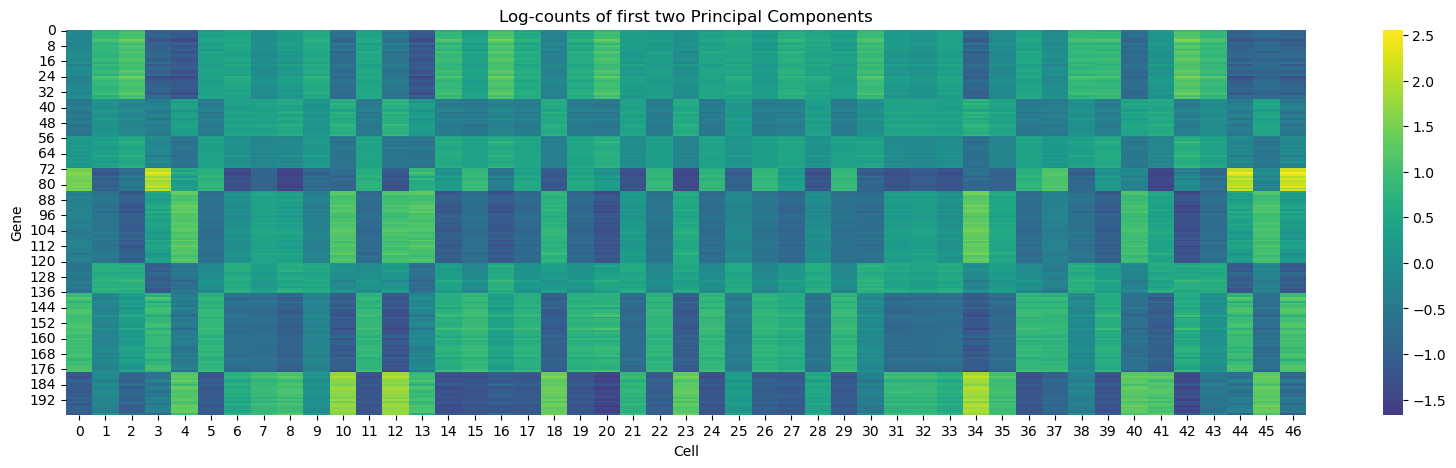

In [83]:
# re-plot the sorted data
plt.figure(figsize=(20, 5))
sns.heatmap(new_data, cmap='viridis', center=0)
plt.xlabel('Cell')
plt.ylabel('Gene')
plt.title('Log-counts of first two Principal Components')

plt.show()

After utilizing the cluster assignments, it appears that more pronounced patterns occur! We are now just plotting a heat map based on our reconstructed data and eigenvectors for the first two PCs, making the clusters more apparent. Thus, we can support Watson's claim that there are 8 clusters. 

In [19]:
%load_ext watermark
%watermark -v -m -p jupyter,numpy,matplotlib

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.27.0

jupyter   : 1.1.1
numpy     : 2.1.1
matplotlib: 3.9.2

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

